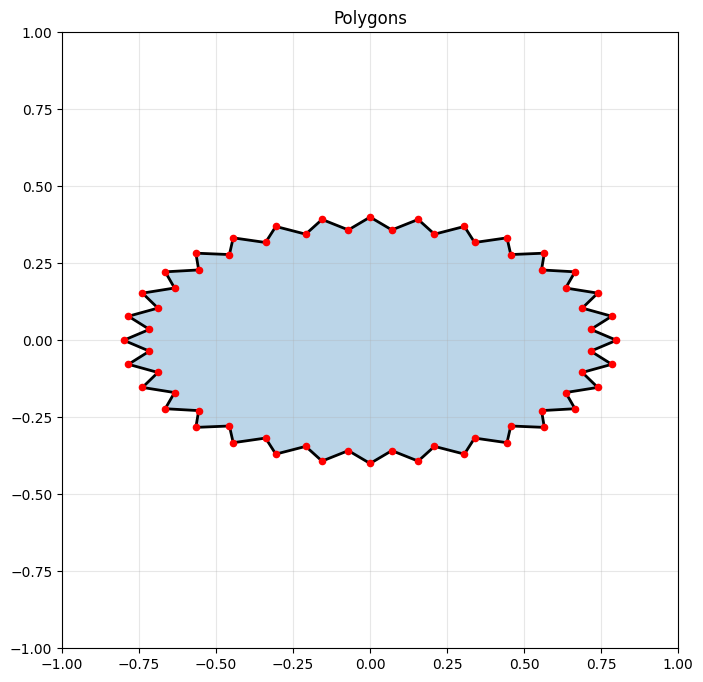

Created 1 surface(s) for visualization


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass

from ainr.ground_truth import generate_polygons
from ainr.vis import plot_polygons, plot_cell_sdf
from ainr.model import ReluMLP

@dataclass
class Surface2D:
    vertices: np.ndarray
    closed: bool

# Generate the same polygons as in mvp4
polygons = generate_polygons('1x32', convex=False, stretch=(1, 0.5), star_ratio=0.9)
plot_polygons(polygons)

# Create Surface2D objects from polygons for visualization
surfaces = [Surface2D(polygon, True) for polygon in polygons]
print(f"Created {len(surfaces)} surface(s) for visualization")


In [9]:
def polygon_sdf(point: np.ndarray, polygon: np.ndarray) -> float:
    """
    Compute signed distance from a point to a polygon.
    Negative inside, positive outside.
    
    Args:
        point: 2D point (x, y)
        polygon: Polygon vertices (n_vertices, 2)
    
    Returns:
        Signed distance value
    """
    n = len(polygon)
    min_dist_sq = float('inf')
    inside = False
    
    for i in range(n):
        v1 = polygon[i]
        v2 = polygon[(i + 1) % n]
        
        # Edge vector and point-to-v1 vector
        edge = v2 - v1
        to_point = point - v1
        
        # Project point onto edge
        edge_len_sq = np.dot(edge, edge)
        if edge_len_sq < 1e-10:
            # Degenerate edge
            dist_sq = np.dot(to_point, to_point)
        else:
            t = np.clip(np.dot(to_point, edge) / edge_len_sq, 0, 1)
            closest = v1 + t * edge
            diff = point - closest
            dist_sq = np.dot(diff, diff)
        
        min_dist_sq = min(min_dist_sq, dist_sq)
        
        # Inside/outside test using winding number
        if v1[1] <= point[1]:
            if v2[1] > point[1]:
                if np.cross(edge, to_point) > 0:
                    inside = not inside
        else:
            if v2[1] <= point[1]:
                if np.cross(edge, to_point) < 0:
                    inside = not inside
    
    dist = np.sqrt(min_dist_sq)
    return -dist if inside else dist


def compute_ground_truth_sdf(points: torch.Tensor, polygons: List[np.ndarray]) -> torch.Tensor:
    """
    Compute ground truth SDF for a batch of points.
    
    Args:
        points: (N, 2) tensor of query points
        polygons: List of polygon vertex arrays
    
    Returns:
        (N,) tensor of SDF values (minimum distance to any polygon)
    """
    points_np = points.cpu().numpy()
    n_points = len(points_np)
    sdf_values = np.zeros(n_points)
    
    for i, point in enumerate(points_np):
        # Compute SDF to each polygon and take minimum absolute value with correct sign
        min_sdf = float('inf')
        for polygon in polygons:
            sdf = polygon_sdf(point, polygon)
            if abs(sdf) < abs(min_sdf):
                min_sdf = sdf
        sdf_values[i] = min_sdf
    
    return torch.tensor(sdf_values, dtype=torch.float32, device=points.device)


def sample_training_points(polygons: List[np.ndarray], 
                           n_surface: int = 1000,
                           n_near: int = 2000, 
                           n_far: int = 500,
                           near_distance: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample training points with emphasis on polygon surfaces and nearby regions.
    
    Args:
        polygons: List of polygon vertex arrays
        n_surface: Number of points to sample on polygon edges
        n_near: Number of points to sample near polygons
        n_far: Number of random points in the domain
        near_distance: Maximum distance for "near" points
    
    Returns:
        Tuple of (points, sdf_values)
    """
    all_points = []
    
    # 1. Sample points on polygon edges
    for polygon in polygons:
        n_edges = len(polygon)
        for i in range(n_edges):
            v1 = polygon[i]
            v2 = polygon[(i + 1) % n_edges]
            # Sample along edge
            n_samples = max(n_surface // (len(polygons) * n_edges), 5)
            t = np.random.rand(n_samples, 1)
            edge_points = v1 + t * (v2 - v1)
            all_points.append(edge_points)
    
    # 2. Sample points near polygon edges
    for polygon in polygons:
        n_edges = len(polygon)
        for i in range(n_edges):
            v1 = polygon[i]
            v2 = polygon[(i + 1) % n_edges]
            edge = v2 - v1
            edge_normal = np.array([-edge[1], edge[0]])
            edge_normal = edge_normal / (np.linalg.norm(edge_normal) + 1e-8)
            
            n_samples = max(n_near // (len(polygons) * n_edges), 10)
            t = np.random.rand(n_samples, 1)
            offsets = (np.random.rand(n_samples, 1) - 0.5) * 2 * near_distance
            
            edge_points = v1 + t * (v2 - v1)
            near_points = edge_points + offsets * edge_normal
            all_points.append(near_points)
    
    # 3. Sample random points in domain [-1, 1]^2
    far_points = np.random.rand(n_far, 2) * 2 - 1
    all_points.append(far_points)
    
    # Combine all points
    points = np.vstack(all_points)
    points_tensor = torch.tensor(points, dtype=torch.float32)
    
    # Compute ground truth SDF
    sdf_tensor = compute_ground_truth_sdf(points_tensor, polygons)
    
    return points_tensor, sdf_tensor


def train_step(model: ReluMLP,
               points: torch.Tensor,
               sdf_gt: torch.Tensor,
               optimizer: optim.Optimizer,
               device: torch.device) -> float:
    """
    Perform a single training step.
    
    Args:
        model: The neural network model
        points: (N, 2) batch of training points
        sdf_gt: (N,) ground truth SDF values
        optimizer: PyTorch optimizer
        device: Device to run on
    
    Returns:
        Loss value
    """
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    points = points.to(device)
    sdf_gt = sdf_gt.to(device)
    sdf_pred = model(points).squeeze()
    
    # Loss: MSE between predicted and ground truth SDF
    loss = torch.nn.functional.mse_loss(sdf_pred, sdf_gt)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()


def evaluate_model(model: ReluMLP,
                   polygons: List[np.ndarray],
                   device: torch.device,
                   n_eval_points: int = 10000) -> dict:
    """
    Evaluate model performance on a held-out set of points.
    
    Args:
        model: The neural network model
        polygons: Ground truth polygons
        device: Device to run on
        n_eval_points: Number of evaluation points
    
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    
    # Sample evaluation points uniformly
    eval_points = torch.rand(n_eval_points, 2) * 2 - 1
    eval_sdf_gt = compute_ground_truth_sdf(eval_points, polygons)
    
    with torch.no_grad():
        eval_points = eval_points.to(device)
        eval_sdf_gt = eval_sdf_gt.to(device)
        eval_sdf_pred = model(eval_points).squeeze()
        
        # Compute metrics
        mse = torch.nn.functional.mse_loss(eval_sdf_pred, eval_sdf_gt).item()
        mae = torch.nn.functional.l1_loss(eval_sdf_pred, eval_sdf_gt).item()
        
        # Compute zero-level set accuracy (classification)
        gt_inside = eval_sdf_gt < 0
        pred_inside = eval_sdf_pred < 0
        accuracy = (gt_inside == pred_inside).float().mean().item()
    
    return {
        'mse': mse,
        'mae': mae,
        'accuracy': accuracy
    }


def train_model(model: ReluMLP,
                polygons: List[np.ndarray],
                surfaces: List = None,
                n_epochs: int = 100,
                batch_size: int = 512,
                lr: float = 1e-3,
                n_surface: int = 1000,
                n_near: int = 2000,
                n_far: int = 500,
                eval_every: int = 10,
                plot_every: int = 20,
                device: torch.device = None):
    """
    End-to-end training loop for the analytic INR model.
    
    Args:
        model: ReluMLP model (pre-initialized)
        polygons: Ground truth polygons
        surfaces: Optional Surface2D objects for visualization
        n_epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate
        n_surface: Number of surface samples per epoch
        n_near: Number of near-surface samples per epoch
        n_far: Number of far samples per epoch
        eval_every: Evaluate every N epochs
        plot_every: Plot visualization every N epochs
        device: Device to train on
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"Starting training on {device}")
    print(f"Model: {model.num_layers} layers, {model.hidden_dim} hidden dims")
    print(f"Training for {n_epochs} epochs with batch_size={batch_size}, lr={lr}")
    print("-" * 80)
    
    start_time = time.time()
    
    for epoch in range(1, n_epochs + 1):
        # Sample new training data each epoch
        train_points, train_sdf = sample_training_points(
            polygons, n_surface=n_surface, n_near=n_near, n_far=n_far
        )
        
        # Shuffle data
        perm = torch.randperm(len(train_points))
        train_points = train_points[perm]
        train_sdf = train_sdf[perm]
        
        # Train for one epoch with mini-batches
        epoch_losses = []
        n_batches = (len(train_points) + batch_size - 1) // batch_size
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(train_points))
            
            batch_points = train_points[start_idx:end_idx]
            batch_sdf = train_sdf[start_idx:end_idx]
            
            loss = train_step(model, batch_points, batch_sdf, optimizer, device)
            epoch_losses.append(loss)
        
        avg_loss = np.mean(epoch_losses)
        
        # Evaluation
        if epoch % eval_every == 0 or epoch == 1:
            metrics = evaluate_model(model, polygons, device)
            elapsed = time.time() - start_time
            
            print(f"Epoch {epoch:3d}/{n_epochs} | "
                  f"Loss: {avg_loss:.6f} | "
                  f"Eval MSE: {metrics['mse']:.6f} | "
                  f"MAE: {metrics['mae']:.6f} | "
                  f"Acc: {metrics['accuracy']:.3f} | "
                  f"Time: {elapsed:.1f}s")
        
        # Visualization
        if epoch % plot_every == 0:
            model.eval()
            plot_cell_sdf(model, surfaces=surfaces,
                         title=f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.6f}")
    
    print("-" * 80)
    print("Training complete!")
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.1f}s ({total_time/n_epochs:.2f}s per epoch)")
    
    # Final evaluation
    final_metrics = evaluate_model(model, polygons, device, n_eval_points=50000)
    print(f"\nFinal Evaluation:")
    print(f"  MSE: {final_metrics['mse']:.6f}")
    print(f"  MAE: {final_metrics['mae']:.6f}")
    print(f"  Accuracy: {final_metrics['accuracy']:.4f}")
    
    return model

print("Training utilities defined successfully!")


Training utilities defined successfully!


Model created with random initialization
Architecture: 3 layers, 8 hidden dims
Skip connections: False
Total parameters: 177


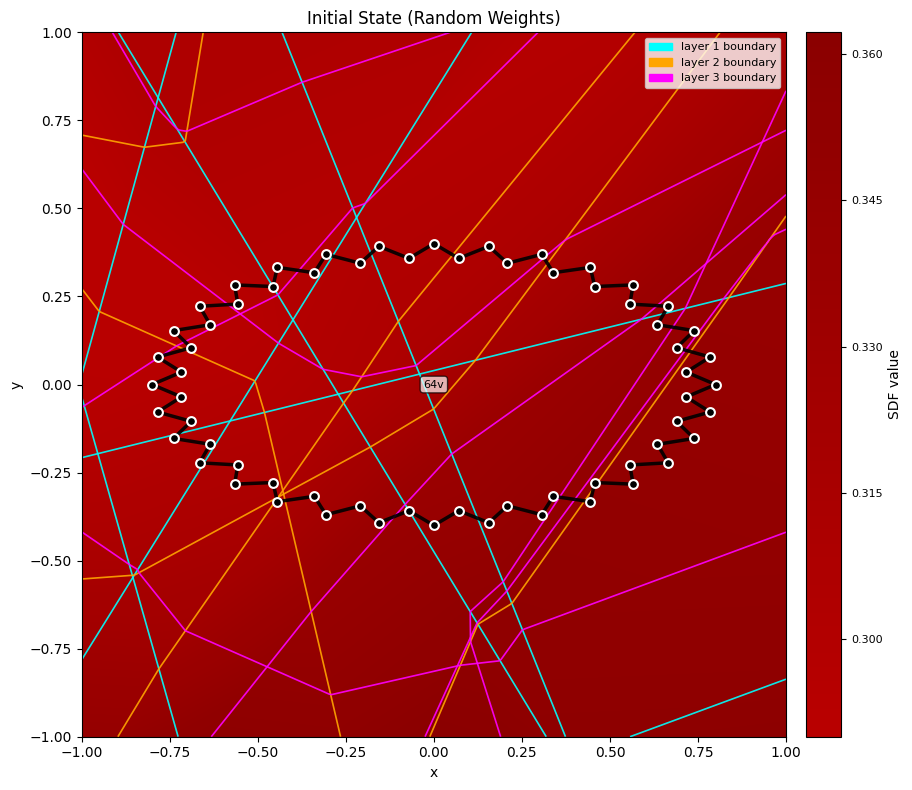

In [10]:
# Create model with RANDOM initialization (no analytic initialization)
# Same architecture: 3 layers, 4 neurons per layer, no skip connections
random_mlp = ReluMLP(
    input_dim=2, 
    hidden_dim=8, 
    num_layers=3, 
    output_dim=1,
    skip_connections=False
)

# Apply random initialization (Xavier/Glorot uniform)
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
#         nn.init.zeros_(m.bias)
# 
# random_mlp.apply(init_weights)

print("Model created with random initialization")
print(f"Architecture: {random_mlp.num_layers} layers, {random_mlp.hidden_dim} hidden dims")
print(f"Skip connections: {random_mlp.skip_connections}")
print(f"Total parameters: {sum(p.numel() for p in random_mlp.parameters())}")

# Show initial state before training (with ground truth surfaces overlaid)
plot_cell_sdf(random_mlp, surfaces=surfaces, title="Initial State (Random Weights)")


TRAINING RANDOMLY INITIALIZED MODEL
Starting training on cpu
Model: 3 layers, 8 hidden dims
Training for 100 epochs with batch_size=512, lr=0.001
--------------------------------------------------------------------------------
Epoch   1/100 | Loss: 0.092640 | Eval MSE: 0.077264 | MAE: 0.233104 | Acc: 0.773 | Time: 4.7s
Epoch  10/100 | Loss: 0.019431 | Eval MSE: 0.096169 | MAE: 0.254381 | Acc: 0.784 | Time: 18.6s
Epoch  20/100 | Loss: 0.012991 | Eval MSE: 0.074354 | MAE: 0.221494 | Acc: 0.724 | Time: 33.9s


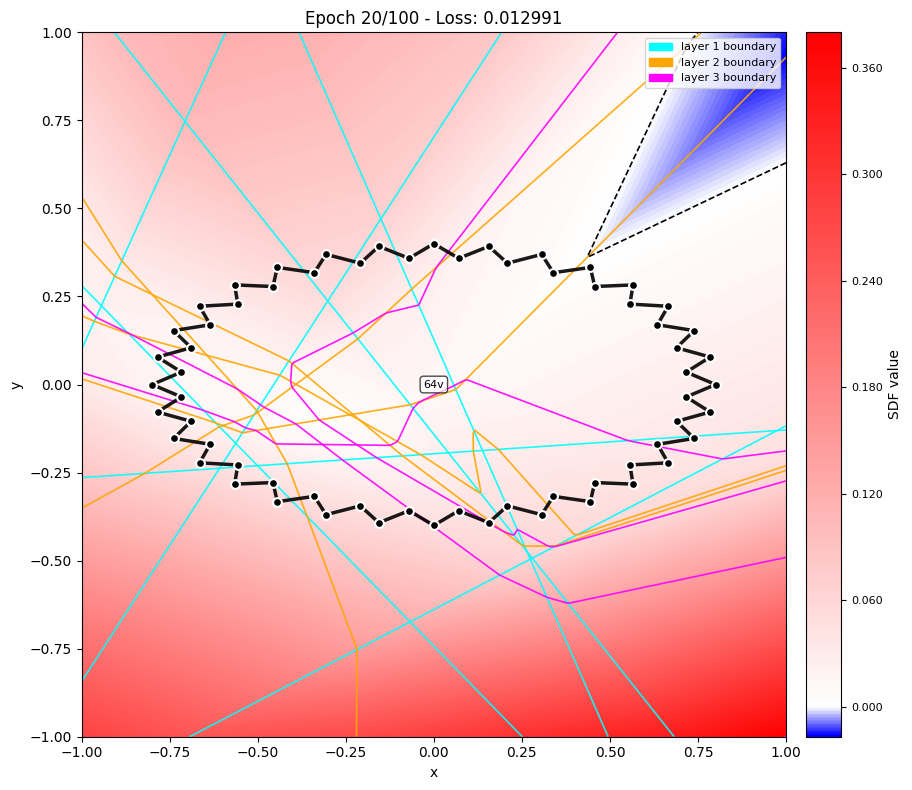

Epoch  30/100 | Loss: 0.007971 | Eval MSE: 0.037929 | MAE: 0.142368 | Acc: 0.858 | Time: 49.9s
Epoch  40/100 | Loss: 0.004655 | Eval MSE: 0.019689 | MAE: 0.104133 | Acc: 0.916 | Time: 65.4s


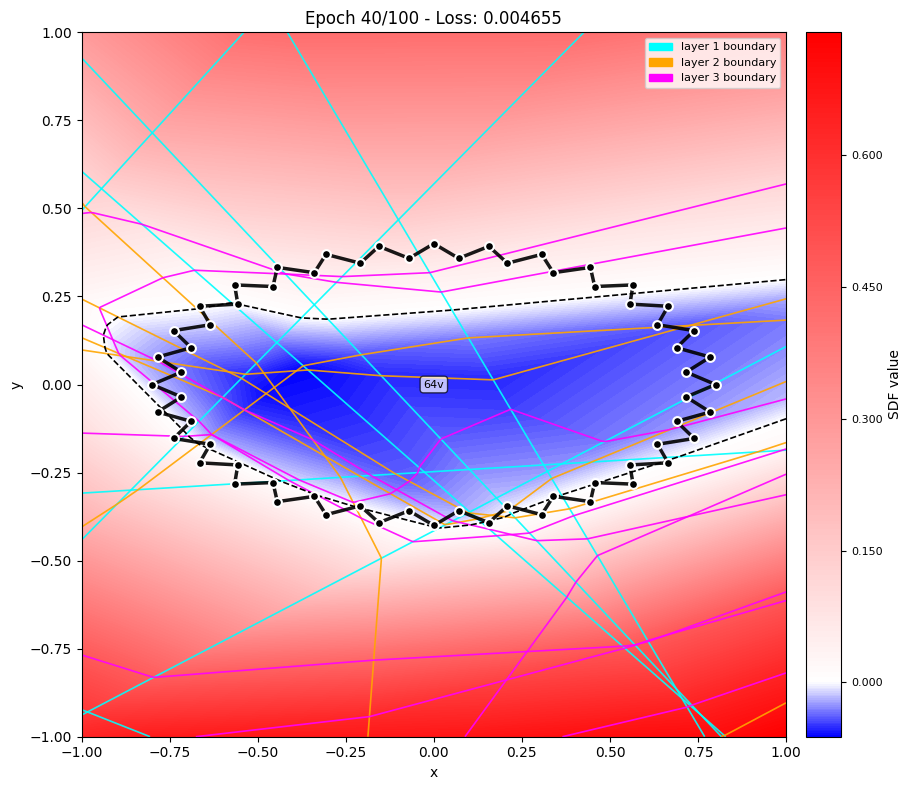

Epoch  50/100 | Loss: 0.001952 | Eval MSE: 0.010053 | MAE: 0.072908 | Acc: 0.951 | Time: 81.6s
Epoch  60/100 | Loss: 0.001010 | Eval MSE: 0.005976 | MAE: 0.055576 | Acc: 0.980 | Time: 97.0s


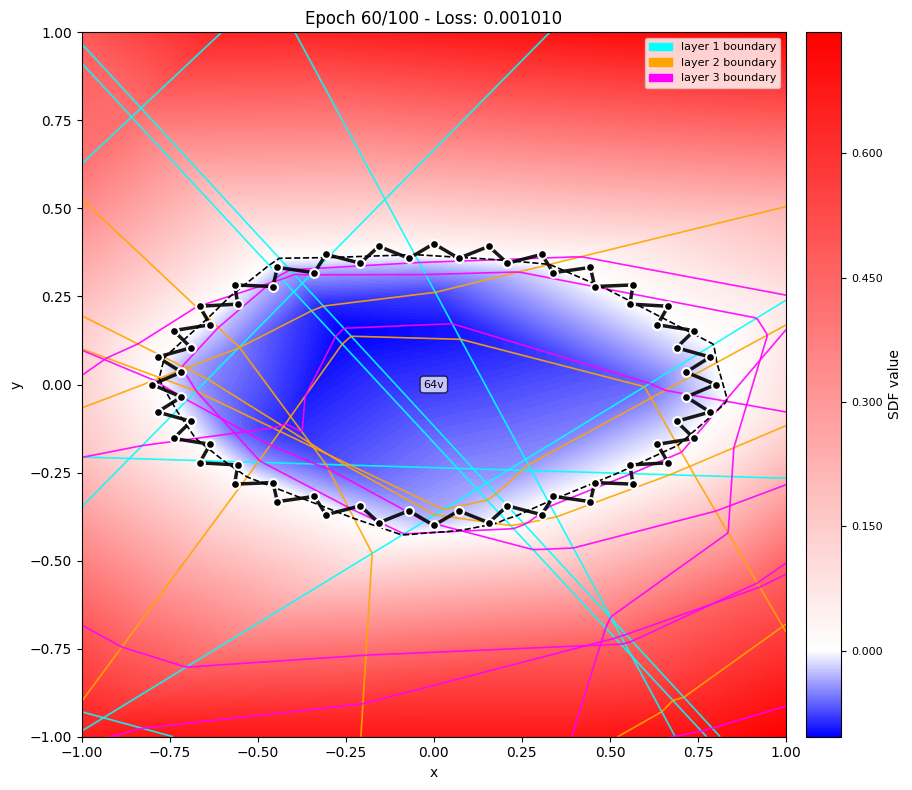

Epoch  70/100 | Loss: 0.000973 | Eval MSE: 0.004053 | MAE: 0.044830 | Acc: 0.981 | Time: 112.8s
Epoch  80/100 | Loss: 0.000783 | Eval MSE: 0.003049 | MAE: 0.039017 | Acc: 0.985 | Time: 128.1s


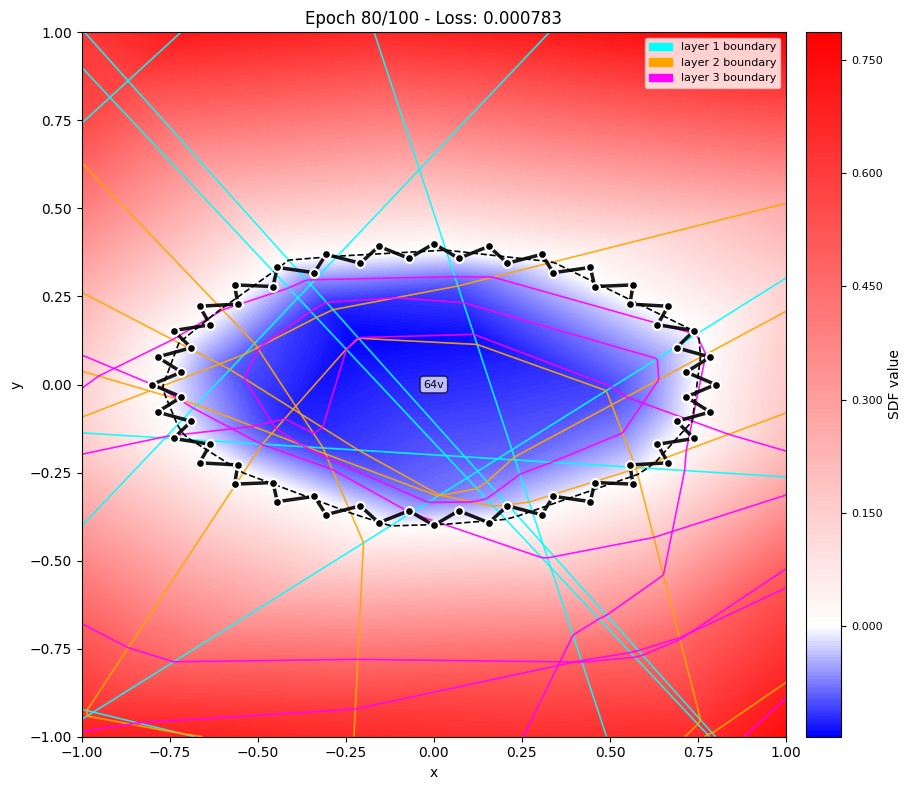

Epoch  90/100 | Loss: 0.000516 | Eval MSE: 0.002359 | MAE: 0.033901 | Acc: 0.987 | Time: 144.3s
Epoch 100/100 | Loss: 0.000430 | Eval MSE: 0.001825 | MAE: 0.029776 | Acc: 0.988 | Time: 160.0s


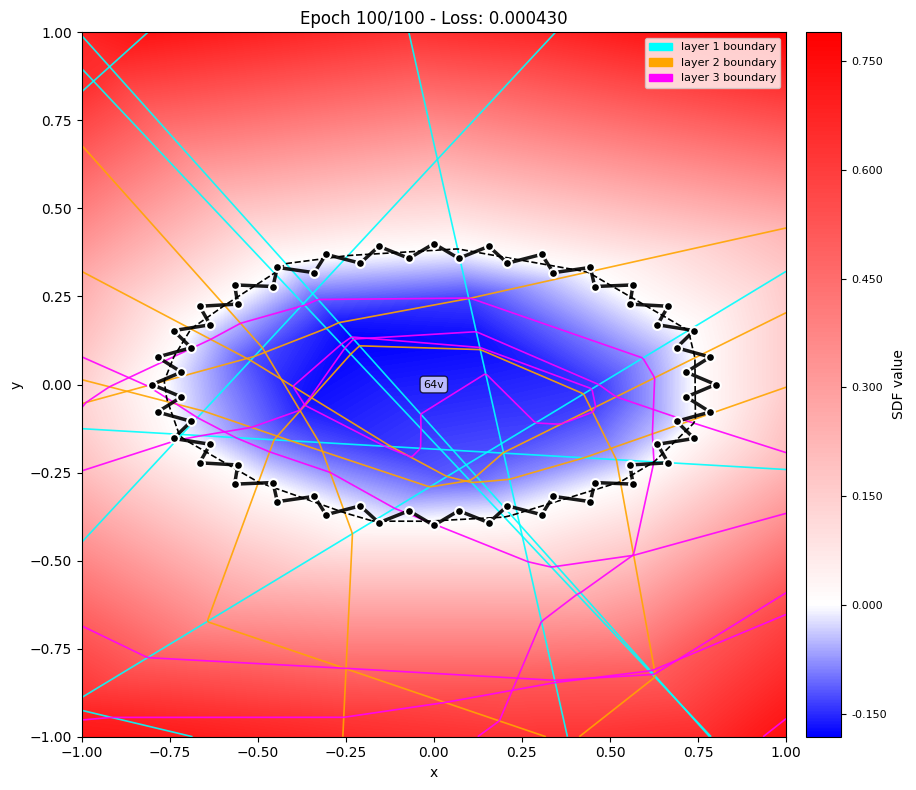

--------------------------------------------------------------------------------
Training complete!
Total time: 160.5s (1.61s per epoch)

Final Evaluation:
  MSE: 0.001848
  MAE: 0.029874
  Accuracy: 0.9873


In [ ]:
# Train the randomly initialized model
print("="*80)
print("TRAINING RANDOMLY INITIALIZED MODEL")
print("="*80)

trained_random_mlp = train_model(
    model=random_mlp,
    polygons=polygons,
    surfaces=surfaces,
    n_epochs=100,
    batch_size=512,
    lr=1e-3,
    n_surface=1000,
    n_near=2000,
    n_far=500,
    eval_every=10,
    plot_every=20,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)


FINAL RESULTS


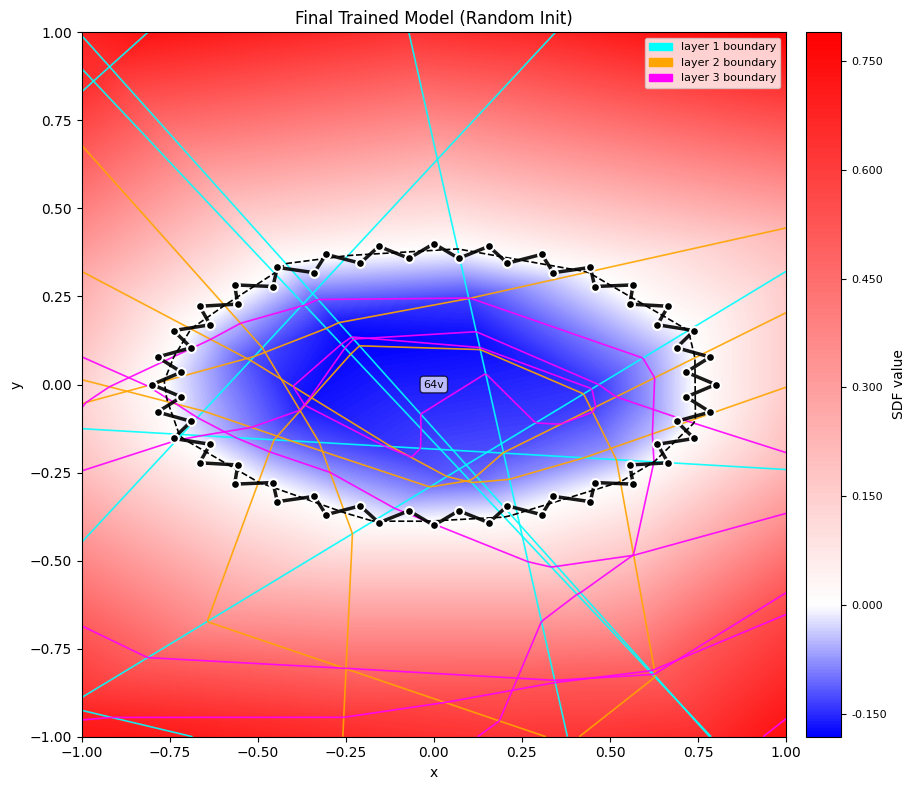


Detailed Final Metrics (100k test points):
  MSE:      0.00187175
  MAE:      0.02998726
  Accuracy: 0.986800 (98.6800%)


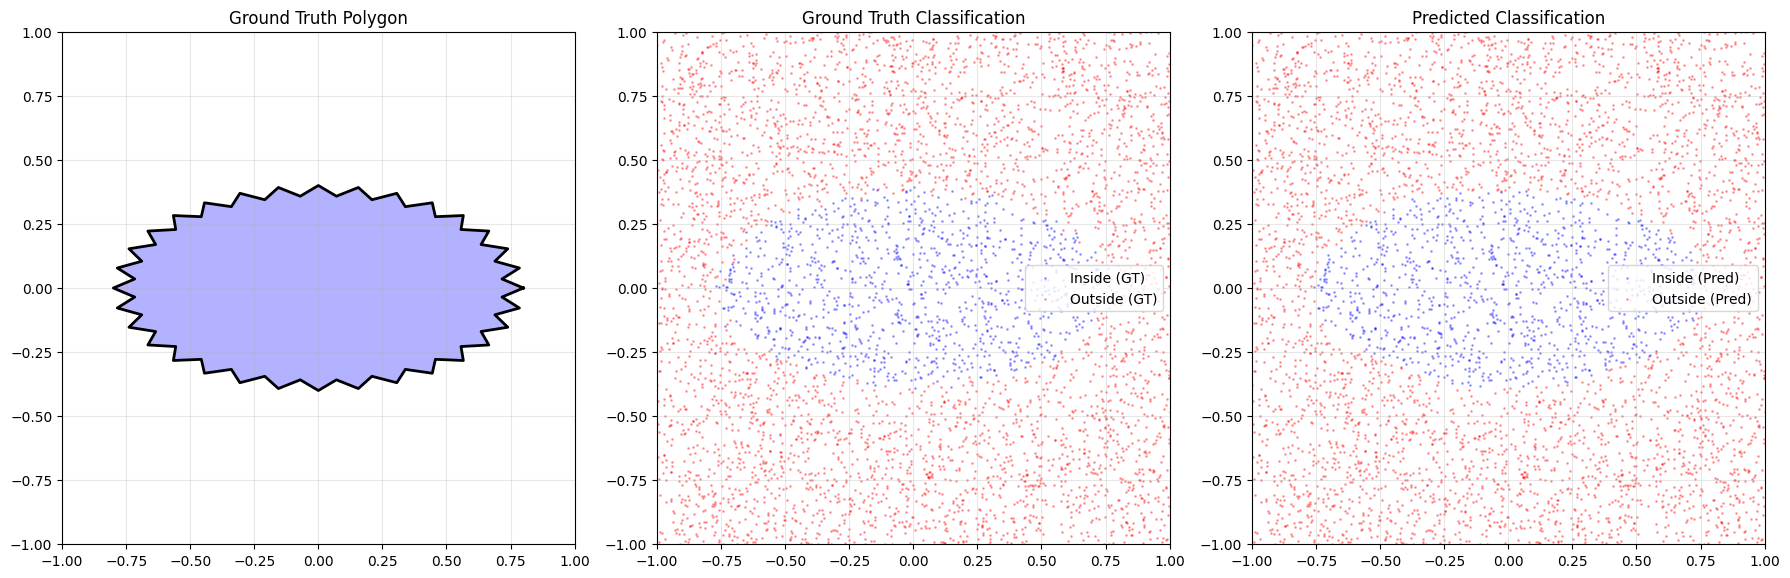


Training complete! The model learned the SDF from random initialization.


In [12]:
# Final visualization and comparison
print("="*80)
print("FINAL RESULTS")
print("="*80)

# Show the final trained model with ground truth surfaces overlaid
plot_cell_sdf(trained_random_mlp, surfaces=surfaces, title="Final Trained Model (Random Init)")

# Compute detailed metrics on a large test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
final_metrics = evaluate_model(trained_random_mlp, polygons, device, n_eval_points=100000)

print("\nDetailed Final Metrics (100k test points):")
print(f"  MSE:      {final_metrics['mse']:.8f}")
print(f"  MAE:      {final_metrics['mae']:.8f}")
print(f"  Accuracy: {final_metrics['accuracy']:.6f} ({final_metrics['accuracy']*100:.4f}%)")

# Visualize some sample predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth polygon
ax = axes[0]
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
for polygon in polygons:
    closed_poly = np.vstack([polygon, polygon[0:1]])
    ax.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2)
    ax.fill(closed_poly[:, 0], closed_poly[:, 1], color='blue', alpha=0.3)
ax.set_title("Ground Truth Polygon")
ax.grid(True, alpha=0.3)

# Sample test points
test_points = torch.rand(5000, 2) * 2 - 1
gt_sdf = compute_ground_truth_sdf(test_points, polygons).numpy()
pred_sdf = trained_random_mlp(test_points.to(device)).detach().cpu().numpy().squeeze()

# Ground truth SDF classification
ax = axes[1]
inside = gt_sdf < 0
outside = gt_sdf >= 0
ax.scatter(test_points[inside, 0], test_points[inside, 1], c='blue', s=1, alpha=0.3, label='Inside (GT)')
ax.scatter(test_points[outside, 0], test_points[outside, 1], c='red', s=1, alpha=0.3, label='Outside (GT)')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.set_title("Ground Truth Classification")
ax.legend()
ax.grid(True, alpha=0.3)

# Predicted SDF classification
ax = axes[2]
pred_inside = pred_sdf < 0
pred_outside = pred_sdf >= 0
ax.scatter(test_points[pred_inside, 0], test_points[pred_inside, 1], c='blue', s=1, alpha=0.3, label='Inside (Pred)')
ax.scatter(test_points[pred_outside, 0], test_points[pred_outside, 1], c='red', s=1, alpha=0.3, label='Outside (Pred)')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.set_title("Predicted Classification")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining complete! The model learned the SDF from random initialization.")
